<a href="https://colab.research.google.com/github/Fakhryrama/Data_Mining/blob/main/KNN%2C_Naive_Bayes%2C_Regresi_Logistik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install library yang diperlukan
!pip install ucimlrepo imbalanced-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score
colnames =["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]
df = pd.read_csv('/content/drive/MyDrive/Datasets/winequality-red.csv', delimiter=';')

In [ ]:
df.shape

(1599, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
# Klasifikasikan kolom quality menjadi tiga kategori
def classify_quality(quality):
    if quality <= 4:
        return 'Low'
    elif 5 <= quality <= 6:
        return 'Medium'
    else:
        return 'High'

df['quality_category'] = df['quality'].apply(classify_quality)

In [ ]:
# Pisahkan fitur dan target
X = df.drop(columns=['quality', 'quality_category'])
y = df['quality_category']

In [ ]:
# Bagi data menjadi training dan testing dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Terapkan SMOTE sebelum pipeline
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Preprocessing numerik
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
        ]), numerical_features)
    ]
)

In [ ]:
# Dictionary pipeline model
pipelines = {
    'KNN': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    'NaiveBayes': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ]),
    'LogisticRegression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
}

In [ ]:
# Hyperparameter tuning untuk masing-masing model
param_grids = {
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    'NaiveBayes': {},  # Tidak banyak hyperparameter untuk GaussianNB
    'LogisticRegression': {
        'classifier__C': [0.1, 1.0, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'liblinear']
    }
}

In [ ]:
# Evaluasi model
results = {}
for model_name, pipeline in pipelines.items():
    print(f'\nTraining model: {model_name}')
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='f1_weighted', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train_resampled, y_train_resampled)

    y_pred = grid_search.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    try:
        auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovr')
    except ValueError:
        auc = 'AUC Error'


Training model: KNN

Training model: NaiveBayes

Training model: LogisticRegression


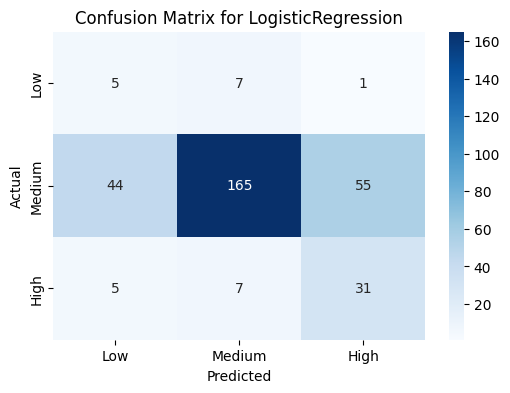

In [ ]:
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
    # Simpan hasil evaluasi
    best_params = grid_search.best_params_ if grid_search.best_params_ else 'No Hyperparameters Tuned'
    results[model_name] = {
        'Best Params': best_params,
        'Accuracy': acc,
        'Balanced Accuracy': balanced_acc,
        'F1-Score': f1,
        'AUC': auc
    }

    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.36      0.72      0.48        43
         Low       0.09      0.38      0.15        13
      Medium       0.92      0.62      0.74       264

    accuracy                           0.63       320
   macro avg       0.46      0.58      0.46       320
weighted avg       0.81      0.63      0.68       320

